### 311 Calls in NYC

Note: a smaller version of the dataset has been provided. Make sure to have it downloaded in the cwd.

If you want to download the full dataset (~41M rows) you can do it [here](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

plt.rcParams['figure.figsize'] = (15, 5)

complaints = pd.read_csv('./data/311_small.csv')  # we'll use the small version here

/var/folders/b3/cjvms6c10k77tgv6k_rw3jbh0000gn/T/ipykernel_34995/3957529669.py:9: DtypeWarning: Columns (8,31,32,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  complaints = pd.read_csv('./data/311_small.csv')  # we'll use the small version here


Depending on the `pandas` version you may get a [`DtypeWarning`](https://pandas.pydata.org/docs/reference/api/pandas.errors.DtypeWarning.html) on some columns. 

In [2]:
complaints.iloc[:, [8,31,32,34,35,36,37]].columns  # these are the columns with inconsistent dtypes

Index(['Incident Zip', 'Vehicle Type', 'Taxi Company Borough',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment'],
      dtype='object')

## 1. Basic exploration

In [3]:
complaints['Complaint Type'].value_counts()[:10]

Complaint Type
HEAT/HOT WATER                         124358
Noise - Residential                     83272
General Construction/Plumbing           57295
Illegal Parking                         56634
Request Large Bulky Item Collection     54515
Blocked Driveway                        51171
Street Condition                        47301
Water System                            28549
Street Light Condition                  26744
UNSANITARY CONDITION                    25171
Name: count, dtype: int64

In [4]:
complaints[['Complaint Type', 'Borough']].value_counts()[:10]

Complaint Type                       Borough  
HEAT/HOT WATER                       BRONX        40419
                                     BROOKLYN     38810
General Construction/Plumbing        BROOKLYN     32272
HEAT/HOT WATER                       MANHATTAN    27572
Noise - Residential                  BROOKLYN     23083
                                     BRONX        22935
Request Large Bulky Item Collection  QUEENS       22427
Illegal Parking                      BROOKLYN     21362
Noise - Residential                  MANHATTAN    20731
Blocked Driveway                     QUEENS       20473
Name: count, dtype: int64

In [5]:
all_counts = complaints['Complaint Type'].value_counts()
type(all_counts)

pandas.core.series.Series

<Axes: xlabel='Complaint Type'>

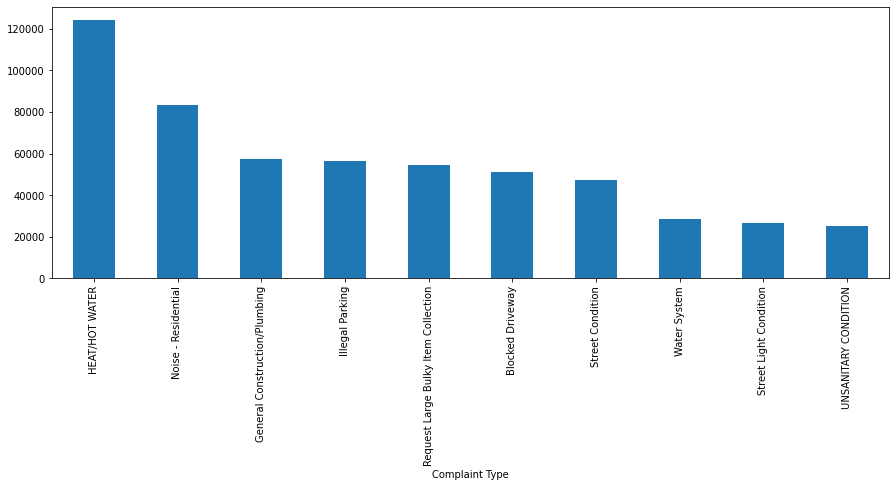

In [6]:
all_counts[:10].plot(kind='bar')

In [7]:
parking_complaints = complaints[complaints['Complaint Type'] == 'Illegal Parking']

In [8]:
parking_complaints.shape

(56634, 41)

### 1.1 Per borough

In [9]:
borough_complaints = complaints['Borough'].value_counts()

In [10]:
borough_parking_complaints = parking_complaints['Borough'].value_counts()

<Axes: xlabel='Borough'>

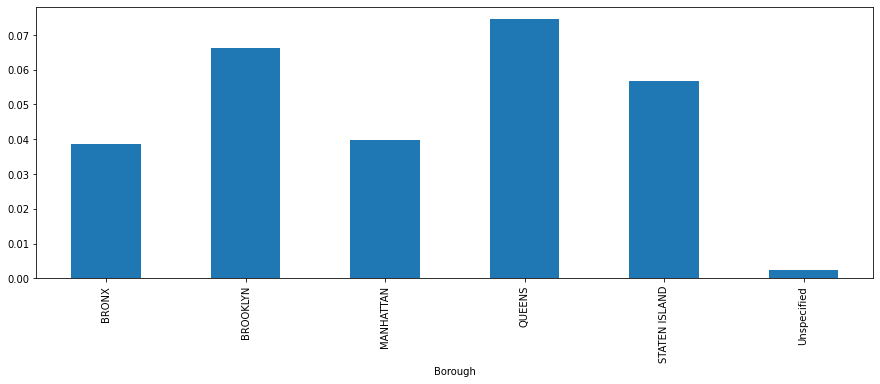

In [11]:
(borough_parking_complaints / borough_complaints).plot(kind='bar')

#### Drill down: 
  * Is there a `Complaint Type` that stands out (percentage-wise) among all complaints per borough?
  * What is the most frequent `Complaint Type` per borough?

## 2. Zip codes

Cleaning the `Incident Zip` column will reveal being not as easy as foreseen.

We'll proceed in the following way:
  * solve one problem at a time
  * create incremental version of a cleaned column
  * at the end, replace the cleaned `pd.Series` on the original dataframe.

In [12]:
zips = complaints['Incident Zip']

In [13]:
zips.isna().sum()

88509

Goal: Reduce this last number.

In [14]:
zips.head()

0    11226
1      NaN
2    11211
3    10032
4    10303
Name: Incident Zip, dtype: object

Quick and dirty: let's see if it works.

In [15]:
zips.dropna().astype(int)

ValueError: invalid literal for int() with base 10: '37214-0065'

Let's try to build a function that will hopefully take care of this.

In [16]:
def clean_string(x):
    try:
        return int(x)    # try this first
    except ValueError:
        if np.isnan(x):  # manage np.nan values
            return -1
        else:
            try:
                return int(x.split('-')[0])  # manage values like '37214-0065'
            except:
                return 0

In [17]:
zips.apply(lambda x: clean_string(x))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Not really an option. More errors arise.

Let's proceed one problem at a time.

### 2.1 Cleaned floats and string.

Goal: transform our series in such a way that only floats and strings are enforced in the series.

In [18]:
def float_and_string(x):
    try:
        return float(x)
    except:
        return str(x)


In [19]:
zip1 = zips.apply(lambda x: float_and_string(x))

In [20]:
zip1.apply(type).unique()

array([<class 'float'>, <class 'str'>], dtype=object)

In [21]:
zip1[zip1.apply(lambda x: isinstance(x, str))]  # what are the remaining strings?

883       37214-0065
40092         NEWARK
40145     10423-0935
63485     90054-0807
64033     18773-9640
76409     08690-1717
90617     11797-9004
146452    44087-2340
154503           UNK
159120             ?
164769    91716-0500
166800       NO IDEA
179235    30353-0942
179493             ?
209339       UNKNOWN
244742    30092-2670
253124             *
329115             *
379814       UNKNOWN
392099    53566-8019
419089    12551-0831
505758    17108-0988
508559    17108-0988
511704       UNKNOWN
549824    85251-3643
606653    11590-5027
654119    11735-3946
682171    11802-9060
685967             *
688809    61702-3517
760548    55164-0437
924175    61702-3517
957902       UNKNOWN
983209    14225-1032
Name: Incident Zip, dtype: object

Let's clean those words. [Regexp](https://docs.python.org/3/library/re.html) to the rescue!

In [22]:
def clean_string(x):
    pt1 = re.compile(r'[a-zA-Z]+')   # any words
    pt2 = re.compile(r'[*]+')        # * character
    pt3 = re.compile(r'[?]+')        # ? character
    if isinstance(x, str):
        for pt in [pt1, pt2, pt3]:
            if re.search(pt, x):
                return np.nan
    return x

In [23]:
zip2 = zip1.apply(lambda x: clean_string(x))

In [24]:
zip2[zip2.apply(lambda x: isinstance(x, str))]   # remaining strings

883       37214-0065
40145     10423-0935
63485     90054-0807
64033     18773-9640
76409     08690-1717
90617     11797-9004
146452    44087-2340
164769    91716-0500
179235    30353-0942
244742    30092-2670
392099    53566-8019
419089    12551-0831
505758    17108-0988
508559    17108-0988
549824    85251-3643
606653    11590-5027
654119    11735-3946
682171    11802-9060
688809    61702-3517
760548    55164-0437
924175    61702-3517
983209    14225-1032
Name: Incident Zip, dtype: object

In [25]:
def split_on_dash(x):
    pat = re.compile(r'\d{5}')    # 5 digits
    p = re.compile(r'-')          # - character
    try:
        if re.search(p, x) and re.match(pat, x):
            return float(x.split('-')[0])
    except:
        return x
            

In [26]:
zip3 = zip2.apply(lambda x: split_on_dash(x))

In [27]:
zip3.apply(type).unique()

array([<class 'float'>], dtype=object)

In [28]:
zip3[zip3.apply(lambda x: isinstance(x, str))]

Series([], Name: Incident Zip, dtype: float64)

Good. Only floats now. Yes, there will be some `np.nan` but this is getting better.

### 2.2 Check Valid Zip codes.

In [29]:
complaints.iloc[76409, 16]

'HAMILTON SQUARE'

In [30]:
complaints.iloc[146452, 16]

'TWINSBURG'

In [31]:
complaints.iloc[179235, 16]

'ATLANTA'

All these are outside NYC.

If you look [here](https://bklyndesigns.com/new-york-city-zip-code/) you'll find that valid NYC zip codes are:
  * Manhattan: 10001-10282
  * Staten Island: 10301-10314
  * Bronx: 10451-10475
  * Queens: 11004-11109, 11351-11697
  * Brooklyn: 11201-11256

In [32]:
def clean_valid_zip_codes(x):
    try:
        code = int(x)
    except:
        return np.nan
    if code < 10001 or code > 11697:
        return np.nan
    elif 10282 < code < 10301:
        return np.nan
    elif 10314 < code < 10451:
        return np.nan
    elif 10475 < code < 11004:
        return np.nan
    elif 11109 < code < 11201:
        return np.nan
    elif 11256 < code < 11351:
        return np.nan
    else:
        return code

In [33]:
zip4 = zip3.apply(lambda x: clean_valid_zip_codes(x))

In [34]:
complaints['Incident Zip'].shape == zip4.shape   # check we didn't loose anything

True

In [35]:
zip4.isna().sum() < complaints['Incident Zip'].isna().sum()   # Did we reduce the number of np.nan?

False

We did not reduce the number of np.nan values. Instead we increased it because of our cleaning strategy.

However, here we are sure to have:
   * only (float) numbers
   * only valid zip codes in NYC area

Let's save our efforts so far.

In [ ]:
complaints['Incident Zip'] = zip4
complaints.to_csv('311_calls_small_almost_cleaned.csv', index=False)   # save to csv file